In [3]:
import os
import pandas as pd
import numpy as np
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from numpy.linalg import norm
from tqdm import tqdm
def extract_features(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    result = model.predict(preprocessed_img).flatten()
    normalized_result = result / norm(result)
    return normalized_result

def load_images_and_extract_features(root_folder, model):
    class_folders = os.listdir(root_folder)
    features_list = []
    labels = []

    for class_folder in class_folders:
        class_path = os.path.join(root_folder, class_folder)
        
        if os.path.isdir(class_path):
            # Extract class label from the folder name
            class_label = class_folder.lower()
            
            # List all image files in the class folder
            image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

            for img_file in image_files:
                img_path = os.path.join(class_path, img_file)
                features = extract_features(img_path, model)
                features_list.append(features)
                labels.append(class_label)

    # Create a DataFrame from the features list and labels
    columns = [f'pixel_{i+1}' for i in range(len(features_list[0]))]
    features_df = pd.DataFrame(features_list, columns=columns)
    features_df['label'] = labels

    return features_df

# Example usage
# model = your_pretrained_model  # Replace with the actual model
root_folder = 'path/to/your/dataset'  # Replace with the path to your dataset

# features_df = load_images_and_extract_features(root_folder, model)

# Save the DataFrame to a CSV file
output_csv_path = 'path/to/save/features.csv'  # Replace with the path to save the output CSV file
# features_df.to_csv(output_csv_path, index=False)

print(f"Features saved to: {output_csv_path}")

Features saved to: path/to/save/features.csv


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def evaluate_performance(model, image_paths, ground_truth_features):
    predicted_features = [extract_features(img_path, model) for img_path in image_paths]
    similarities = [cosine_similarity([predicted_feature], [ground_truth_feature])[0, 0] for predicted_feature, ground_truth_feature in zip(predicted_features, ground_truth_features)]

    # Example: Calculate accuracy
    correct_predictions = sum(similarity > threshold for similarity in similarities)
    accuracy = correct_predictions / len(similarities)

    return accuracy

# Example usage
model = your_pretrained_model  # Replace with the actual model
image_paths = your_image_paths  # Replace with the paths to your images
ground_truth_features = your_ground_truth_features  # Replace with the ground truth features

accuracy = evaluate_performance(model, image_paths, ground_truth_features)
print(f"Accuracy: {accuracy}")

In [ ]:
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Load your labeled dataset
# Replace this with your own dataset loading code
def load_dataset():
    # Example: Load images and corresponding labels (0 or 1)
    # You need to adapt this based on your dataset structure
    images_class0 = [...]  # List of image paths for class 0
    images_class1 = [...]  # List of image paths for class 1
    labels_class0 = [0] * len(images_class0)
    labels_class1 = [1] * len(images_class1)
    
    # Combine data from both classes
    images = images_class0 + images_class1
    labels = labels_class0 + labels_class1

    return images, labels

# Load the dataset
images, labels = load_dataset()

# Extract features for each image in the dataset
features = [extract_features(cv2.imread(img, cv2.IMREAD_GRAYSCALE)) for img in images]

# Convert features to numpy array
X = np.array(features)
y = np.array(labels)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a k-Nearest Neighbors classifier
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


# Edge Extraction

In [33]:
import cv2
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import pandas as pd

# Function to load and process the fashion dataset with a specific label
def load_dataset_with_label(csv_path, result, target_label):
    df_fashion = pd.read_csv(csv_path, index_col=0)
    filtered_df = df_fashion[df_fashion['label'] == target_label]
    result.append((filtered_df['label'].values, filtered_df.drop('label', axis=1).values))


# Load your dataset (replace this with your actual dataset loading code)
def load_dataset(address):
    data = pd.read_csv(address)
    labels = data['label'].tolist()
    # Extract pixel values for all images in the dataset
    dataset = data.iloc[:, 1:].astype(int).values.tolist()
    # Each element in 'dataset' should be a list of pixel values for one image.
    return dataset, labels

def extract_features(image):
    # Convert the image to 8-bit if it's not already
    if image.dtype != np.uint8:
        image = cv2.convertScaleAbs(image)

    # Assume single-channel image (grayscale)
    hist = cv2.calcHist([image], [0], None, [8], [0, 256])

    return hist.flatten()

# Choose an input image (replace this with your actual input image)
input_image = cv2.imread(r'Test\Ankle Boot\80.jpg', cv2.IMREAD_GRAYSCALE)
# Resize the input image to (28, 28)
input_image = cv2.resize(input_image, (28, 28))
input_features = extract_features(input_image)

# Proses classification

# Load dataset and extract features
# Load the fashion dataset for label 0
result = []
load_dataset_with_label(r'Dataset\Dataset_Fashion(11-Label).csv', result, target_label=0)
labels, dataset = result[0] #[0] From Process Classification
features = [extract_features(np.array(img).reshape(28, 28)) for img in dataset]

# Convert the list of features to a numpy array
X = np.array(features)

# Create a Nearest Neighbors model
knn_model = NearestNeighbors(n_neighbors=76, metric='euclidean')
knn_model.fit(X)


# Reshape input features to match the shape of the training features
input_features = input_features.reshape(1, -1)

# Find the k nearest neighbors
distances, indices = knn_model.kneighbors(input_features)

In [34]:
all_indices = np.array(indices)
# Calculate ranking-based accuracy
num_correct_neighbors = np.sum(all_indices == np.arange(all_indices.shape[1])[np.newaxis, :])

# Print intermediate results for debugging
print("All Indices:")
print(all_indices)
print("\nArange Indices:")
print(np.arange(all_indices.shape[1])[np.newaxis, :])

# If the values in all_indices are not within the range of indices, adjust the comparison
adjusted_indices = np.arange(all_indices.shape[1])[np.newaxis, :]
num_correct_neighbors = np.sum(np.isin(all_indices, adjusted_indices))
total_possible_matches = all_indices.size

# Ranking-based accuracy
ranking_accuracy_histogram = num_correct_neighbors / total_possible_matches

print(f'Ranking-based Accuracy: {ranking_accuracy_histogram * 100:.2f}%')

All Indices:
[[80  4  8  1 54  2 34 89  3 88 31  5 82 33 98 56 94 32 86 52 96  0 30 15
  36 62 40 48 50 39  9 58  6 44 78 38 13 12 60 57 37 95 83 70 42 85 11 97
  19  7 63 35 71 47 53 79 46 92 59 90 10 49 77 45 84 73 16 14 68 51 18 99
  66 69 65 55]]

Arange Indices:
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
  48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
  72 73 74 75]]
Ranking-based Accuracy: 75.00%


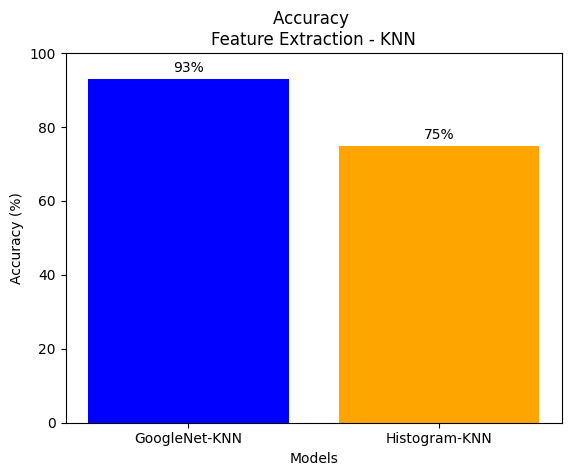

In [35]:
import matplotlib.pyplot as plt

# Data
models = ['GoogleNet-KNN', 'Histogram-KNN']
accuracies = [int(0.93 *100), int(ranking_accuracy_histogram*100)]  # Replace with your actual accuracy values

# Plotting the bar chart
fig, ax = plt.subplots()
bars = ax.bar(models, accuracies, color=['blue', 'orange'])

# Adding accuracy values as text on top of the bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{acc}%', ha='center', va='bottom')

plt.ylim(0, 100)  # Set the y-axis limit based on your accuracy scale
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy \nFeature Extraction - KNN')
plt.show()


In [ ]:
# Display the input image
plt.subplot(1, 6, 1)
plt.imshow(input_image, cmap='gray')
plt.title('Input Image')
plt.axis('off')

# Display the k-nearest neighbor images
for i in range(5):
    neighbor_index = indices[0, i]
    neighbor_image = dataset[neighbor_index]
    plt.figure(figsize=(10,8))
    plt.subplot(1, 6, i + 2)
    plt.imshow(np.array(neighbor_image).reshape(28, 28), cmap='gray')
    plt.title(f'Neighbor {i + 1}')
    plt.axis('off')

plt.show()

# Feature Extraction From RGB input load CSV

In [14]:
result = 0
def load_dataset(address, result):
    data = pd.read_csv(address,index_col=0)
    data = data[data.loc[:, 'label'] == result]
    # labels = data['label'].tolist()
    # Extract pixel values for all images in the dataset
    dataset = data.iloc[:, 1:].astype(int).values.tolist()
    # Each element in 'dataset' should be a list of pixel values for one image.
    return dataset

# Load the CSV file with fashion data
df_fashion = load_dataset(r'Dataset\Dataset_Fashion(11-Label).csv',result)

[[253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  252,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  252,
  251,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  255,
  255,
  254,
  251,
  252,
  252,
  251,
  251,
  250,
  251,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  242,
  225,
  248,
  255,
  255,
  255,
  255,
  255,
  255,
  255,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  249,
  255,
  144,
  20,
  196,
  224,
  231,
  241,
  218,
  208,
  194,
  203,
  254,
  252,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  253,
  249,


# Use VGG

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Input
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Function to load and process the fashion dataset with a specific label
def load_dataset_with_label(csv_path, result, target_label):
    df_fashion = pd.read_csv(csv_path, index_col=0)
    filtered_df = df_fashion[df_fashion['label'] == target_label]
    result.append((filtered_df['label'].values, filtered_df.drop('label', axis=1).values))

# Load the fashion dataset for label 0
result = []
load_dataset_with_label(r'Dataset\Dataset_Fashion(11-Label).csv', result, target_label=0)
labels_fashion, pixels_fashion = result[0] #[0] From Process Classification

# Extract labels and pixels
# labels_fashion = df_fashion['label'].values
# pixels_fashion = df_fashion.drop('label', axis=1).values

# Normalize pixel values to be between 0 and 1
pixels_fashion = pixels_fashion / 255.0

# Assuming pixels_fashion has shape (num_samples, num_pixels)
# Determine the size of the images
image_size = int(np.sqrt(pixels_fashion.shape[1]))

print(f"Image size: {image_size}")
print(f"Total number of pixels: {pixels_fashion.shape[1]}")

# Check if the number of pixels matches the expected size for reshaping
expected_size = image_size * image_size * 1
if pixels_fashion.shape[1] != expected_size:
    print("Error: Number of pixels doesn't match the expected size.")
    print(f"Expected size: {expected_size}")
else:
    # Reshape pixel data to images
    pixels_fashion = pixels_fashion.reshape(-1, image_size, image_size, 1)

# Convert labels to categorical (one-hot encoding)
label_encoder_fashion = LabelEncoder()
labels_fashion = label_encoder_fashion.fit_transform(labels_fashion)

# Load the pre-trained VGG16 model and modify it for feature extraction
base_model = Sequential([
    Input(shape=(image_size, image_size, 1)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Flatten(),
    Dense(4096, activation='relu'),
    Dense(4096, activation='relu')
])
input_layer = Input(shape=(image_size, image_size, 1))
x = base_model(input_layer)
model_for_feature_extraction = Model(inputs=input_layer, outputs=x)

# Function to load and process RGB image to grayscale
def load_and_process_rgb_image(image_path):
    # Load the image in RGB format
    rgb_image = cv2.imread(image_path)
    rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)

    # Convert RGB to grayscale
    grayscale_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)

    # Resize the image to match the input size expected by the VGG16 model
    resized_image = cv2.resize(grayscale_image, (28, 28))

    # Expand dimensions to match the expected input shape (batch size, height, width, channels)
    processed_image = np.expand_dims(resized_image, axis=-1)
    processed_image = np.expand_dims(processed_image, axis=0)

    return processed_image

# Extract features from the Dataset 
features_fashion = model_for_feature_extraction.predict(pixels_fashion)

# Ensure the features from the fashion dataset match the shape of the RGB image features
features_fashion_flat = features_fashion.reshape(features_fashion.shape[0], -1)

# Create a Nearest Neighbors model
nn_model = NearestNeighbors(n_neighbors=90, metric='euclidean')
nn_model.fit(features_fashion_flat)

# Example usage to load and process RGB image
rgb_image_path = r'Dataset\Ankle Boot\0.jpg'
processed_rgb_image = load_and_process_rgb_image(rgb_image_path)

# Extract features from the RGB image
features_rgb_image = model_for_feature_extraction.predict(processed_rgb_image)

# Flatten the features arrays
features_rgb_image_flat = features_rgb_image.reshape(1, 4096)

# Reshape input features to match the shape of the training features
input_features = features_rgb_image_flat

# Find the k nearest neighbors
distances, indices = nn_model.kneighbors(input_features)

Image size: 28
Total number of pixels: 784
1/1 [==============================] - 0s 93ms/step


In [20]:
all_indices = np.array(indices)
# Calculate ranking-based accuracy
num_correct_neighbors = np.sum(all_indices == np.arange(all_indices.shape[1])[np.newaxis, :])

# Print intermediate results for debugging
print("All Indices:")
print(all_indices)
print("\nArange Indices:")
print(np.arange(all_indices.shape[1])[np.newaxis, :])

# If the values in all_indices are not within the range of indices, adjust the comparison
adjusted_indices = np.arange(all_indices.shape[1])[np.newaxis, :]
num_correct_neighbors = np.sum(np.isin(all_indices, adjusted_indices))
total_possible_matches = all_indices.size

# Ranking-based accuracy
ranking_accuracy_vgg = num_correct_neighbors / total_possible_matches

print(f'Ranking-based Accuracy: {ranking_accuracy_vgg * 100:.2f}%')


All Indices:
[[81 21 76 20 67 92  9  7 27 25 23 24 37 29 72  6 28 63 75 22 35 51 50 42
  68 99 17 46 38 36 64 87 39 26  0 40 61 10 71 47 59 83 53 16 70 48 77 78
   5 90 30 79 34 18 65 15 56 12 60 33 74 57 84 73 96 32  2 69 86 31 55  3
  45 19 49 41 85 97 11 82 88 89 14 54  8 98 91 43  4 62]]

Arange Indices:
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
  48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
  72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89]]
Ranking-based Accuracy: 92.22%


## Using Resnet


In [3]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [4]:
def identity_block(X,filter):
    # copy tensor to variable called x_skip
    x_skip = X
    # layer 1 
    X = tf.keras.layers.Conv2D(filter,(3,3),padding='same')(X)
    X = tf.keras.layers.BatchNormalization(axis=3)(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    # Layer 2
    X = tf.keras.layers.Conv2D(filter,(3,3),padding='same')(X)
    X = tf.keras.layers.BatchNormalization(axis=3)(X)
    
    # Add Resiude
    X = tf.keras.layers.Add()([X,x_skip])
    X = tf.keras.layers.Activation('relu')(X)
    return X

# Convolutional block -> add the bootleck to the layer to solve the unbalance shape from skip layer
def Convolutional_block(X,filter):
    X_skip = X
    # layer 1 
    X = tf.keras.layers.Conv2D(filter,(3,3),padding='same',strides=(2,2))(X)
    X = tf.keras.layers.BatchNormalization(axis=3)(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    # Layer 2
    X = tf.keras.layers.Conv2D(filter,(3,3),padding='same')(X)
    X = tf.keras.layers.BatchNormalization(axis=3)(X)
    
    # processing residue with conv(1,1)
    X_skip = tf.keras.layers.Conv2D(filter,(1,1),strides=(2,2),padding='same')(X_skip)
    
    # add residue
    X = tf.keras.layers.Add()([X,X_skip])
    X = tf.keras.layers.Activation('relu')(X)
    return X

def ResNet34(shape=(28,28,1),classes=11):
    # step 1 -> setup(input layer)
    X_input = tf.keras.layers.Input(shape)
    X = tf.keras.layers.ZeroPadding2D((3,3))(X_input)
    
    # step 2 -> (initial conv layer along with maxpool)
    X = tf.keras.layers.Conv2D(64,kernel_size=(7,7),strides=2,padding='same')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPool2D(pool_size=(3,3),strides=2,padding='same')(X)
    
    # step 3 ->define the size of sub blocks and initila filter size
    block_layers=[3,4,6,3]
    filter_size = 64
    # step 4 add the resnet block
    for i in range(4):
        if i==0:
            # for sub-block 1 residual/convolutional block not needed increment value
            for j in range(block_layers[i]):
                X = identity_block(X,filter_size)
        else:
            # for sub-block 1++ residula/convolutional block need increment value
            filter_size = filter_size*2
            X = Convolutional_block(X,filter_size)
            for j in range(block_layers[i]-1):
                X = identity_block(X,filter_size)
    
    # step 4 end dense network with fcp (full conencted layer)
    X = tf.keras.layers.AveragePooling2D(pool_size=(2,2),padding='same')(X)
    model = tf.keras.models.Model(inputs=X_input,outputs=X,name='ResNet34')
    return model

In [36]:
model_resnet_34 = ResNet34()
model_resnet_34.summary()

Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 34, 34, 1)   0           ['input_14[0][0]']               
                                                                                                  
 conv2d_49 (Conv2D)             (None, 17, 17, 64)   3200        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 17, 17, 64)  256         ['conv2d_49[0][0]']              
 rmalization)                                                                              

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Input
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Function to load and process the fashion dataset with a specific label
def load_dataset_with_label(csv_path, result, target_label):
    df_fashion = pd.read_csv(csv_path, index_col=0)
    filtered_df = df_fashion[df_fashion['label'] == target_label]
    result.append((filtered_df['label'].values, filtered_df.drop('label', axis=1).values))

# Load the fashion dataset for label 0
result = []
load_dataset_with_label(r'Dataset\Dataset_Fashion(11-Label).csv', result, target_label=0)
labels_fashion, pixels_fashion = result[0] #[0] From Process Classification

# Extract labels and pixels
# labels_fashion = df_fashion['label'].values
# pixels_fashion = df_fashion.drop('label', axis=1).values

# Normalize pixel values to be between 0 and 1
pixels_fashion = pixels_fashion / 255.0

# Assuming pixels_fashion has shape (num_samples, num_pixels)
# Determine the size of the images
image_size = int(np.sqrt(pixels_fashion.shape[1]))

print(f"Image size: {image_size}")
print(f"Total number of pixels: {pixels_fashion.shape[1]}")

# Check if the number of pixels matches the expected size for reshaping
expected_size = image_size * image_size * 1
if pixels_fashion.shape[1] != expected_size:
    print("Error: Number of pixels doesn't match the expected size.")
    print(f"Expected size: {expected_size}")
else:
    # Reshape pixel data to images
    pixels_fashion = pixels_fashion.reshape(-1, image_size, image_size, 1)

# Convert labels to categorical (one-hot encoding)
label_encoder_fashion = LabelEncoder()
labels_fashion = label_encoder_fashion.fit_transform(labels_fashion)

# Load the pre-trained VGG16 model and modify it for feature extraction
model_for_feature_extraction = ResNet34()

# Function to load and process RGB image to grayscale
def load_and_process_rgb_image(image_path):
    # Load the image in RGB format
    rgb_image = cv2.imread(image_path)
    rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)

    # Convert RGB to grayscale
    grayscale_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)

    # Resize the image to match the input size expected by the VGG16 model
    resized_image = cv2.resize(grayscale_image, (28, 28))

    # Expand dimensions to match the expected input shape (batch size, height, width, channels)
    processed_image = np.expand_dims(resized_image, axis=-1)
    processed_image = np.expand_dims(processed_image, axis=0)

    return processed_image

# Extract features from the Dataset 
features_fashion = model_for_feature_extraction.predict(pixels_fashion)

# Ensure the features from the fashion dataset match the shape of the RGB image features
features_fashion_flat = features_fashion.reshape(features_fashion.shape[0], -1)

# Create a Nearest Neighbors model
nn_model = NearestNeighbors(n_neighbors=90, metric='euclidean')
nn_model.fit(features_fashion_flat)

# Example usage to load and process RGB image
rgb_image_path = r'Dataset\Ankle Boot\0.jpg'
processed_rgb_image = load_and_process_rgb_image(rgb_image_path)

# Extract features from the RGB image
features_rgb_image = model_for_feature_extraction.predict(processed_rgb_image)

# Flatten the features arrays
features_rgb_image_flat = features_rgb_image.reshape(1, -1)

# Reshape input features to match the shape of the training features
input_features = features_rgb_image_flat

# Find the k nearest neighbors
distances, indices = nn_model.kneighbors(input_features)

Image size: 28
Total number of pixels: 784
1/1 [==============================] - 1s 508ms/step


In [22]:
all_indices = np.array(indices)
# Calculate ranking-based accuracy
num_correct_neighbors = np.sum(all_indices == np.arange(all_indices.shape[1])[np.newaxis, :])

# Print intermediate results for debugging
print("All Indices:")
print(all_indices)
print("\nArange Indices:")
print(np.arange(all_indices.shape[1])[np.newaxis, :])

# If the values in all_indices are not within the range of indices, adjust the comparison
adjusted_indices = np.arange(all_indices.shape[1])[np.newaxis, :]
num_correct_neighbors = np.sum(np.isin(all_indices, adjusted_indices))
total_possible_matches = all_indices.size

# Ranking-based accuracy
ranking_accuracy_resnet = num_correct_neighbors / total_possible_matches

print(f'Ranking-based Accuracy: {ranking_accuracy_resnet * 100:.2f}%')

All Indices:
[[81 21 67 25 24 20 72 23 76 29 63 27 42 39  6 37 35  9 99 22 51 10  7 36
  28 92 68 87 64 83 48 75 77 56 30 71 53  5 17 60 78 73 26 96 90 38 16 40
  84 74 70 50 59 79 46 57 61 12 33 18  0 15 47 65 89 85 97 98 86 88 55 34
  11 45 32 41  8 43 82  4 54 69 49 95 31 62  3 58 91  2]]

Arange Indices:
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
  48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
  72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89]]
Ranking-based Accuracy: 91.11%


## GoogleNet

In [7]:
from keras.models import Model
from keras.layers import Input,Conv2D,MaxPooling2D,AveragePooling2D,Flatten,GlobalAveragePooling2D,Dense,Dropout,BatchNormalization
from tensorflow.keras.layers import concatenate
from keras.layers import  Lambda
import tensorflow as tf

In [8]:
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
  # Input: 
  # - f1: number of filters of the 1x1 convolutional layer in the first path
  # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
  # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
  # - f4: number of filters of the 1x1 convolutional layer in the fourth path

  # 1st path:
  path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

  # 2nd path
  path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

  # 3rd path
  path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

  # 4th path
  path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
  path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

  output_layer = concatenate([path1, path2, path3, path4], axis = -1)

  return output_layer

def GoogLeNet():
    input_layer = Input(shape=(28, 28, 1))
    X = Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu')(input_layer)
    X = MaxPooling2D(pool_size=(3, 3), strides=2)(X)
    X = BatchNormalization()(X)
    X = Conv2D(filters=64, kernel_size=(1, 1), strides=1, padding='same', activation='relu')(X)
    X = Conv2D(filters=192, kernel_size=(3, 3), strides=1, padding='same', activation='relu')(X)
    X = BatchNormalization()(X)
    X = MaxPooling2D(pool_size=(3, 3), strides=2)(X)
    X = Inception_block(X, f1=64, f2_conv1=96, f2_conv3=128, f3_conv1=16, f3_conv5=32, f4=32)
    X = Inception_block(X, f1=128, f2_conv1=128, f2_conv3=192, f3_conv1=32, f3_conv5=96, f4=64)
    X = MaxPooling2D(pool_size=(3, 3), strides=2)(X)
    X = Inception_block(X, f1=192, f2_conv1=96, f2_conv3=208, f3_conv1=16, f3_conv5=48, f4=64)
    X = GlobalAveragePooling2D(name='GAPL')(X)
    model = Model(input_layer, X, name='GoogLeNetSingleOutput')
    return model

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Input
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Function to load and process the fashion dataset with a specific label
def load_dataset_with_label(csv_path, result, target_label):
    df_fashion = pd.read_csv(csv_path, index_col=0)
    filtered_df = df_fashion[df_fashion['label'] == target_label]
    result.append((filtered_df['label'].values, filtered_df.drop('label', axis=1).values))

# Load the fashion dataset for label 0
result = []
load_dataset_with_label(r'Dataset\Dataset_Fashion(11-Label).csv', result, target_label=0)
labels_fashion, pixels_fashion = result[0] #[0] From Process Classification

# Extract labels and pixels
# labels_fashion = df_fashion['label'].values
# pixels_fashion = df_fashion.drop('label', axis=1).values

# Normalize pixel values to be between 0 and 1
pixels_fashion = pixels_fashion / 255.0

# Assuming pixels_fashion has shape (num_samples, num_pixels)
# Determine the size of the images
image_size = int(np.sqrt(pixels_fashion.shape[1]))

print(f"Image size: {image_size}")
print(f"Total number of pixels: {pixels_fashion.shape[1]}")

# Check if the number of pixels matches the expected size for reshaping
expected_size = image_size * image_size * 1
if pixels_fashion.shape[1] != expected_size:
    print("Error: Number of pixels doesn't match the expected size.")
    print(f"Expected size: {expected_size}")
else:
    # Reshape pixel data to images
    pixels_fashion = pixels_fashion.reshape(-1, image_size, image_size, 1)

# Convert labels to categorical (one-hot encoding)
label_encoder_fashion = LabelEncoder()
labels_fashion = label_encoder_fashion.fit_transform(labels_fashion)

# Load the pre-trained VGG16 model and modify it for feature extraction
model_for_feature_extraction = GoogLeNet()

# Function to load and process RGB image to grayscale
def load_and_process_rgb_image(image_path):
    # Load the image in RGB format
    rgb_image = cv2.imread(image_path)
    rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)

    # Convert RGB to grayscale
    grayscale_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)

    # Resize the image to match the input size expected by the VGG16 model
    resized_image = cv2.resize(grayscale_image, (28, 28))

    # Expand dimensions to match the expected input shape (batch size, height, width, channels)
    processed_image = np.expand_dims(resized_image, axis=-1)
    processed_image = np.expand_dims(processed_image, axis=0)

    return processed_image

# Extract features from the Dataset 
features_fashion = model_for_feature_extraction.predict(pixels_fashion)

# Ensure the features from the fashion dataset match the shape of the RGB image features
features_fashion_flat = features_fashion.reshape(features_fashion.shape[0], -1)

# Create a Nearest Neighbors model
nn_model = NearestNeighbors(n_neighbors=90, metric='euclidean')
nn_model.fit(features_fashion_flat)

# Example usage to load and process RGB image
rgb_image_path = r'Dataset\Ankle Boot\0.jpg'
processed_rgb_image = load_and_process_rgb_image(rgb_image_path)

# Extract features from the RGB image
features_rgb_image = model_for_feature_extraction.predict(processed_rgb_image)

# Flatten the features arrays
features_rgb_image_flat = features_rgb_image.reshape(1, -1)

# Reshape input features to match the shape of the training features
input_features = features_rgb_image_flat

# Find the k nearest neighbors
distances, indices = nn_model.kneighbors(input_features)

Image size: 28
Total number of pixels: 784
1/1 [==============================] - 1s 1s/step


In [10]:
all_indices = np.array(indices)
# Calculate ranking-based accuracy
num_correct_neighbors = np.sum(all_indices == np.arange(all_indices.shape[1])[np.newaxis, :])

# Print intermediate results for debugging
print("All Indices:")
print(all_indices)
print("\nArange Indices:")
print(np.arange(all_indices.shape[1])[np.newaxis, :])

# If the values in all_indices are not within the range of indices, adjust the comparison
adjusted_indices = np.arange(all_indices.shape[1])[np.newaxis, :]
num_correct_neighbors = np.sum(np.isin(all_indices, adjusted_indices))
total_possible_matches = all_indices.size

# Ranking-based accuracy
ranking_accuracy_google= num_correct_neighbors / total_possible_matches

print(f'Ranking-based Accuracy: {ranking_accuracy_google * 100:.2f}%')

All Indices:
[[34  0 39 31 56 35 37  9  2  5 50 83 36  6  7 92 48 30  3 81 40 38 33 32
  42 79 82 10 89 88  4 85 78 98 90 46 63 47 54 70 71 73 96 53 74 67 76 60
  72 75 44 59 68 21 24 12 77 57 65 87 61 14 58 64 25 29 11  8 23 15 86 22
  51 20 99 17 80 27 13 84 16 28 19 49 97 41 62 55 45 18]]

Arange Indices:
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
  48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
  72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89]]
Ranking-based Accuracy: 93.33%


The greatest Model from the result :
- GoogleNet

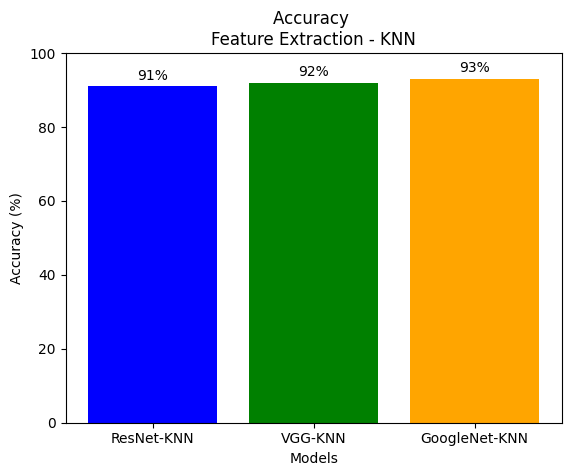

In [29]:
import matplotlib.pyplot as plt

# Data
models = ['ResNet-KNN', 'VGG-KNN', 'GoogleNet-KNN']
accuracies = [int(ranking_accuracy_resnet *100), int(ranking_accuracy_vgg*100), int(ranking_accuracy_google*100)]  # Replace with your actual accuracy values

# Plotting the bar chart
fig, ax = plt.subplots()
bars = ax.bar(models, accuracies, color=['blue', 'green', 'orange'])

# Adding accuracy values as text on top of the bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{acc}%', ha='center', va='bottom')

plt.ylim(0, 100)  # Set the y-axis limit based on your accuracy scale
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy \nFeature Extraction - KNN')
plt.show()



# Gray Scale

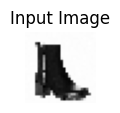

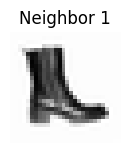

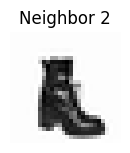

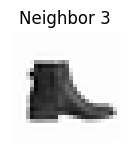

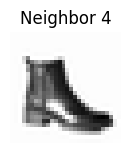

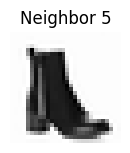

In [2]:
# Display the input image
plt.subplot(1, 6, 1)
plt.imshow(processed_rgb_image.squeeze(), cmap='gray')  # Assuming processed_rgb_image is a single grayscale image
plt.title('Input Image')
plt.axis('off')

# Display the k-nearest neighbor images
for i in range(5):
    neighbor_index = indices[0, i]
    neighbor_image = pixels_fashion[neighbor_index].reshape(image_size, image_size, 1)
    plt.figure(figsize=(10,8))
    plt.subplot(1, 6, i + 2)
    plt.imshow(np.array(neighbor_image).reshape(image_size, image_size), cmap='gray')
    plt.title(f'Neighbor {i + 1}')
    plt.axis('off')

plt.show()

# RGB -> Process with Gray scale image and return with RGB

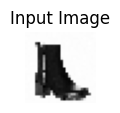

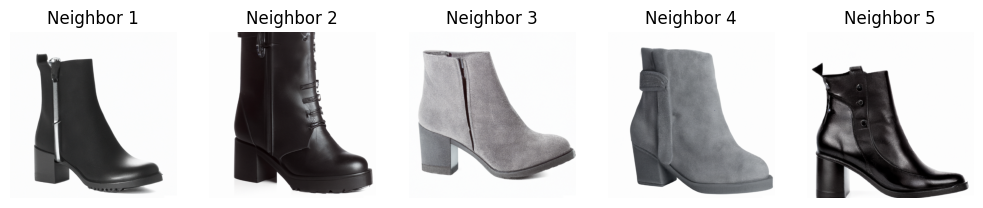

In [3]:
def load_images_from_folder(folder_path):
    images = []
    indices = []
    
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        
        if os.path.isfile(label_path):  # Memastikan hanya file yang diambil, bukan folder
            label_index = int(label.split('.')[0])  # Mengambil indeks dari nama file (misal: '0.jpg' -> 0)
            
            img = cv2.imread(label_path, cv2.IMREAD_COLOR)
            
            if img is not None:
                img = cv2.resize(img, (28, 28))
                images.append(img.flatten())
                indices.append(label_index)
    
    return np.array(images), np.array(indices)

def load_images_from_folder_rgb(folder_path):
    images = []
    indices = []
    
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        
        if os.path.isfile(label_path):  # Make sure to only load files, not folders
            label_index = int(label.split('.')[0])  # Extract index from the file name (e.g., '0.jpg' -> 0)
            
            img = cv2.imread(label_path, cv2.IMREAD_COLOR)  # Load the image in color (RGB)
            
            images.append(img)
            indices.append(label_index)
    
    return np.array(images), np.array(indices)
    
# Load images from the folder
folder_path = r'Dataset\Ankle Boot'
# Load RGB images from the folder
folder_images_rgb, folder_indices_rgb = load_images_from_folder_rgb(folder_path)

# Display the input image
plt.subplot(1, 6, 1)
plt.imshow(processed_rgb_image.squeeze(), cmap='gray')  # Assuming processed_rgb_image is a single grayscale image
plt.title('Input Image')
plt.axis('off')

# Display the k-nearest neighbor images from the folder (RGB)
plt.figure(figsize=(15, 8))
for i in range(5):
    neighbor_index = folder_indices_rgb[i] if folder_indices_rgb.shape[0] > 0 else 0  # Use folder_indices
    neighbor_image_rgb = folder_images_rgb[neighbor_index]

    # plt.subplot(2, 3, i + 1)
    # plt.imshow(neighbor_image_rgb)
    # plt.title(f'Neighbor {i + 1}\nIndex: {neighbor_index}')
    # plt.axis('off')
    plt.subplot(1, 6, i + 2)
    plt.imshow(neighbor_image_rgb)
    plt.title(f'Neighbor {i + 1}')
    plt.axis('off')

plt.show()



### Evaluate Performance


In [3]:
from keras.models import Model
from keras.layers import Input,Conv2D,MaxPooling2D,AveragePooling2D,Flatten,GlobalAveragePooling2D,Dense,Dropout,BatchNormalization
from tensorflow.keras.layers import concatenate
from keras.layers import  Lambda
import tensorflow as tf

In [4]:
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
  # Input: 
  # - f1: number of filters of the 1x1 convolutional layer in the first path
  # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
  # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
  # - f4: number of filters of the 1x1 convolutional layer in the fourth path

  # 1st path:
  path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

  # 2nd path
  path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

  # 3rd path
  path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

  # 4th path
  path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
  path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

  output_layer = concatenate([path1, path2, path3, path4], axis = -1)

  return output_layer

def GoogLeNet():
    input_layer = Input(shape=(28, 28, 1))
    X = Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu')(input_layer)
    X = MaxPooling2D(pool_size=(3, 3), strides=2)(X)
    X = BatchNormalization()(X)
    X = Conv2D(filters=64, kernel_size=(1, 1), strides=1, padding='same', activation='relu')(X)
    X = Conv2D(filters=192, kernel_size=(3, 3), strides=1, padding='same', activation='relu')(X)
    X = BatchNormalization()(X)
    X = MaxPooling2D(pool_size=(3, 3), strides=2)(X)
    X = Inception_block(X, f1=64, f2_conv1=96, f2_conv3=128, f3_conv1=16, f3_conv5=32, f4=32)
    X = Inception_block(X, f1=128, f2_conv1=128, f2_conv3=192, f3_conv1=32, f3_conv5=96, f4=64)
    X = MaxPooling2D(pool_size=(3, 3), strides=2)(X)
    X = Inception_block(X, f1=192, f2_conv1=96, f2_conv3=208, f3_conv1=16, f3_conv5=48, f4=64)
    X = GlobalAveragePooling2D(name='GAPL')(X)
    model = Model(input_layer, X, name='GoogLeNetSingleOutput')
    return model

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Input
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Function to load and process the fashion dataset with a specific label
def load_dataset_with_label(csv_path, result, target_label):
    df_fashion = pd.read_csv(csv_path, index_col=0)
    filtered_df = df_fashion[df_fashion['label'] == target_label]
    result.append((filtered_df['label'].values, filtered_df.drop('label', axis=1).values))

# Load the fashion dataset for label 0
result = []
load_dataset_with_label(r'Dataset\Dataset_Fashion(11-Label).csv', result, target_label=0)
labels_fashion, pixels_fashion = result[0] #[0] From Process Classification

# Extract labels and pixels
# labels_fashion = df_fashion['label'].values
# pixels_fashion = df_fashion.drop('label', axis=1).values

# Normalize pixel values to be between 0 and 1
pixels_fashion = pixels_fashion / 255.0

# Assuming pixels_fashion has shape (num_samples, num_pixels)
# Determine the size of the images
image_size = int(np.sqrt(pixels_fashion.shape[1]))

print(f"Image size: {image_size}")
print(f"Total number of pixels: {pixels_fashion.shape[1]}")

# Check if the number of pixels matches the expected size for reshaping
expected_size = image_size * image_size * 1
if pixels_fashion.shape[1] != expected_size:
    print("Error: Number of pixels doesn't match the expected size.")
    print(f"Expected size: {expected_size}")
else:
    # Reshape pixel data to images
    pixels_fashion = pixels_fashion.reshape(-1, image_size, image_size, 1)

# Convert labels to categorical (one-hot encoding)
label_encoder_fashion = LabelEncoder()
labels_fashion = label_encoder_fashion.fit_transform(labels_fashion)

# Load the pre-trained VGG16 model and modify it for feature extraction
model_for_feature_extraction = GoogLeNet()

# Function to load and process RGB image to grayscale
def load_and_process_rgb_image(image_path):
    # Load the image in RGB format
    rgb_image = cv2.imread(image_path)
    rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)

    # Convert RGB to grayscale
    grayscale_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)

    # Resize the image to match the input size expected by the VGG16 model
    resized_image = cv2.resize(grayscale_image, (28, 28))

    # Expand dimensions to match the expected input shape (batch size, height, width, channels)
    processed_image = np.expand_dims(resized_image, axis=-1)
    processed_image = np.expand_dims(processed_image, axis=0)

    return processed_image

# Extract features from the Dataset 
features_fashion = model_for_feature_extraction.predict(pixels_fashion)

# Ensure the features from the fashion dataset match the shape of the RGB image features
features_fashion_flat = features_fashion.reshape(features_fashion.shape[0], -1)

# Create a Nearest Neighbors model
nn_model = NearestNeighbors(n_neighbors=90, metric='euclidean')
nn_model.fit(features_fashion_flat)

# Example usage to load and process RGB image
rgb_image_path = r'Dataset\Ankle Boot\0.jpg'
processed_rgb_image = load_and_process_rgb_image(rgb_image_path)

# Extract features from the RGB image
features_rgb_image = model_for_feature_extraction.predict(processed_rgb_image)

# Flatten the features arrays
features_rgb_image_flat = features_rgb_image.reshape(1, -1)

# Reshape input features to match the shape of the training features
input_features = features_rgb_image_flat

# Find the k nearest neighbors
distances, indices = nn_model.kneighbors(input_features)

Image size: 28
Total number of pixels: 784
1/1 [==============================] - 4s 4s/step


In [6]:
all_indices = np.array(indices)
# Calculate ranking-based accuracy
num_correct_neighbors = np.sum(all_indices == np.arange(all_indices.shape[1])[np.newaxis, :])

# Print intermediate results for debugging
print("All Indices:")
print(all_indices)
print("\nArange Indices:")
print(np.arange(all_indices.shape[1])[np.newaxis, :])

# If the values in all_indices are not within the range of indices, adjust the comparison
adjusted_indices = np.arange(all_indices.shape[1])[np.newaxis, :]
num_correct_neighbors = np.sum(np.isin(all_indices, adjusted_indices))
total_possible_matches = all_indices.size

# Ranking-based accuracy
ranking_accuracy_google= num_correct_neighbors / total_possible_matches

print(f'Ranking-based Accuracy: {ranking_accuracy_google * 100:.2f}%')

All Indices:
[[34  2 56 92 39  0 54 33  5 83  6 31 96 37 50 36  7  9  3  8 35 30 40 32
  48 88 70 38 98 46  4 63 89 78 42 86 85 90 10 82 81 49 12 79 59 53 47 75
  71 77 65 68 73 44 74 67 99 76 57 94 60 72 87 24 11 25 21 84 29 20 18 16
  80 14 17 19 23 58 61  1 22 28 52 51 15 27 69 13 55 97]]

Arange Indices:
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
  48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
  72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89]]
Ranking-based Accuracy: 92.22%
